# Building Knn and RFC on Credit Card Defaults

Using the credit card default dataset, I built two hpyertuned classifiers based on precision score. As well, I looked at if Cross Fold Validation had any impact on the classifiers.

In [6]:
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

## Exploring Data

In [7]:
df = pd.read_excel("C:/Users/willjdsouza/Desktop/Data Science Fundamentals/3253 - Machine Learning/Assignments/default of credit card clients.xls", 
                   sheet = 0, skiprows= 1, header = 0)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Sample of Data Visualizations

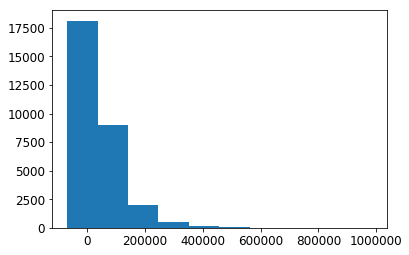

In [8]:
plt.hist(df['BILL_AMT2'])
plt.show()

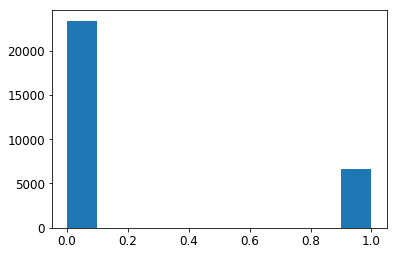

In [9]:
plt.hist(df["default payment next month"])
plt.show()

Looking atht he data via histograms, above is just a small sample, overall teh data is typically skewed.

## Data Pre-Processing & Building Pipeline

In [10]:
from sklearn.model_selection import train_test_split
X = df[['LIMIT_BAL','SEX', 'EDUCATION', 'MARRIAGE', 'AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
        'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT5']]
y = df['default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# splitting the dataset via a simple train/test, assigining variables for indepedent and depedent factors

y_train_1 = (y_train == 1)
y_test_1 = (y_test == 1)
# setting the value for == 1 (1 represents credit card default, the binary value we are trying to predict)

x_train_num = X_train[['LIMIT_BAL', 'AGE','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
        'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT5']]

cat_attribs = X_train[['SEX', 'EDUCATION', 'MARRIAGE', 'AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]

cat_encoder = CategoricalEncoder(encoding="onehot-dense")
cat_attribs_1hot = cat_encoder.fit_transform(cat_attribs)
cat_attribs_1hot
# seperating the features by categorical and numerical data, then encoding the categorical vairables

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

num_attribs = list(x_train_num)
cat_attribs = list(cat_attribs)
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ]) 

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
])
credit_prepared = full_pipeline.fit_transform(X_train)
#Creating a full pipeline to transform the variables

C:\Users\willjdsouza\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## GridSearch on hyperparameters (RFC, Knn)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 4, 6, 7, 10, 20, 50, 100]}
  ]

rdfc = RandomForestClassifier()
grid_search = GridSearchCV(rdfc, param_grid,
scoring='precision')
grid_search.fit(credit_prepared, y_train_1)
grid_search.best_params_
#hypertuning randomforest n_estimators

from sklearn.neighbors import KNeighborsClassifier

param_grid1 = [
    {'n_neighbors': [3, 4, 5, 7, 10, 20, 50]}
  ]

knn = KNeighborsClassifier()
grid_search1 = GridSearchCV(knn, param_grid1,
scoring='precision')
grid_search1.fit(credit_prepared, y_train_1)
grid_search1.best_params_
#hypertuning knn n_neighbors

{'n_neighbors': 50}

In [11]:
print("RandomForestBestParams:", grid_search.best_params_)
print("KnnBestParams:", grid_search1.best_params_)

RandomForestBestParams: {'n_estimators': 100}
KnnBestParams: {'n_neighbors': 50}


In [13]:
## LOOKING AT THE COMBINATIONS FOR RANDOM FOREST
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.478775876463 {'n_estimators': 3}
0.568081605 {'n_estimators': 4}
0.600266404864 {'n_estimators': 6}
0.555574768932 {'n_estimators': 7}
0.615724144314 {'n_estimators': 10}
0.637784242836 {'n_estimators': 20}
0.646096145596 {'n_estimators': 50}
0.652015520937 {'n_estimators': 100}


In [14]:
## LOOKING AT THE COMBINATIONS FOR KNN
cvres1 = grid_search1.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres1["params"]):
    print(mean_score, params)

0.478775876463 {'n_neighbors': 3}
0.568081605 {'n_neighbors': 4}
0.600266404864 {'n_neighbors': 5}
0.555574768932 {'n_neighbors': 7}
0.615724144314 {'n_neighbors': 10}
0.637784242836 {'n_neighbors': 20}
0.646096145596 {'n_neighbors': 50}


## Fitting classifiers and 4-fold cv 

NOW I FIT BOTH MODELS TO EACH CLASSIFIER WITH 4 CROSS FOLD VALIDATION

In [18]:
rdfc = RandomForestClassifier(n_estimators=100)
rdfc.fit(credit_prepared, y_train_1)
knn = KNeighborsClassifier(n_neighbors = 50 )
knn.fit(credit_prepared, y_train_1)

from sklearn.model_selection import cross_val_predict
y_train_pred_rdfc = cross_val_predict(rdfc, credit_prepared, y_train_1, cv=4)
y_train_pred_knn = cross_val_predict(knn, credit_prepared, y_train_1, cv=4)

## Confusion Matrix for Classifiers

In [19]:
#RANDOM FOREST CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_1, y_train_pred_rdfc)

array([[17644,  1033],
       [ 3379,  1944]], dtype=int64)

In [20]:
#KNN CONFUSION MATRIX
confusion_matrix(y_train_1, y_train_pred_knn) 

array([[18066,   611],
       [ 4088,  1235]], dtype=int64)

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

print ("RDFC Precision:", (precision_score(y_train_1, y_train_pred_rdfc)))
print ("RDFC Recall:",(recall_score(y_train_1, y_train_pred_rdfc)))
print ("RDFC F1 Score:", (f1_score(y_train_1, y_train_pred_rdfc)))

print ("KNN Precision:", (precision_score(y_train_1, y_train_pred_knn)))
print ("KNN Recall:",(recall_score(y_train_1, y_train_pred_knn)))
print ("KNN F1 Score:", (f1_score(y_train_1, y_train_pred_knn)))

RDFC Precision: 0.653006382264
RDFC Recall: 0.365207589705
RDFC F1 Score: 0.46843373494
KNN Precision: 0.669014084507
KNN Recall: 0.232012023295
KNN F1 Score: 0.344538987306


## ROC Curve & AUC Scores

In [24]:
from sklearn.metrics import roc_curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

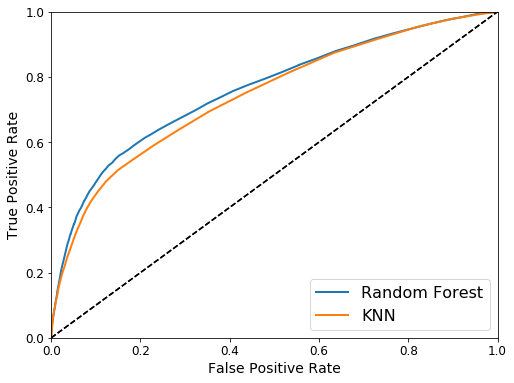

In [27]:
y_probas_forest = cross_val_predict(rdfc, credit_prepared, y_train_1, cv=4, method="predict_proba")
y_probas_knn = cross_val_predict(knn, credit_prepared, y_train_1, cv=4, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_1,y_scores_forest)

y_scores_knn = y_probas_knn[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train_1, y_scores_knn)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_knn, tpr_knn, "KNN")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score
print("ROC AUC RANDOM FOREST SCORE:", roc_auc_score(y_train_1, y_scores_forest))
print("ROC AUC KNN SCORE:", roc_auc_score(y_train_1, y_scores_knn))

ROC AUC RANDOM FOREST SCORE: 0.760056524559
ROC AUC KNN SCORE: 0.7427629742


# CV with 5 folds

In [32]:
y_train_pred_rdfc_5 = cross_val_predict(rdfc, credit_prepared, y_train_1, cv=5)
y_train_pred_knn_5 = cross_val_predict(knn, credit_prepared, y_train_1, cv=5)

In [33]:
#RANDOM FOREST 5 FOLDS CONFUSION MATRIX
confusion_matrix(y_train_1, y_train_pred_rdfc_5)

array([[17676,  1001],
       [ 3389,  1934]], dtype=int64)

In [34]:
#KNN 5 FOLDS CONFUSION MATRIX
confusion_matrix(y_train_1, y_train_pred_knn_5)

array([[18060,   617],
       [ 4060,  1263]], dtype=int64)

In [35]:
print ("RDFC Precision:", (precision_score(y_train_1, y_train_pred_rdfc_5)))
print ("RDFC Recall:",(recall_score(y_train_1, y_train_pred_rdfc_5)))
print ("RDFC F1 Score:", (f1_score(y_train_1, y_train_pred_rdfc_5)))

print ("KNN Precision:", (precision_score(y_train_1, y_train_pred_knn_5)))
print ("KNN Recall:",(recall_score(y_train_1, y_train_pred_knn_5)))
print ("KNN F1 Score:", (f1_score(y_train_1, y_train_pred_knn_5)))

RDFC Precision: 0.658943781942
RDFC Recall: 0.36332894984
RDFC F1 Score: 0.46839428433
KNN Precision: 0.671808510638
KNN Recall: 0.237272214916
KNN F1 Score: 0.350687213661


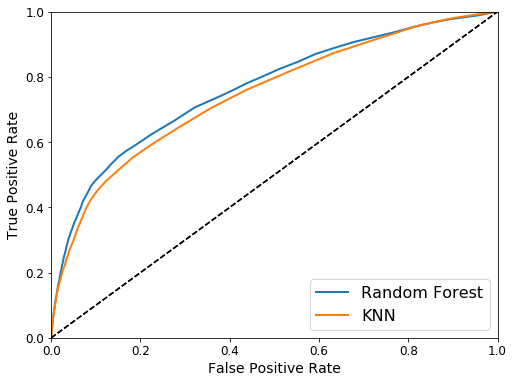

In [36]:
y_probas_forest_5 = cross_val_predict(rdfc, credit_prepared, y_train_1, cv=5, method="predict_proba")
y_probas_knn_5 = cross_val_predict(knn, credit_prepared, y_train_1, cv=5, method="predict_proba")

y_scores_forest_5 = y_probas_forest_5[:, 1]
fpr_forest_5, tpr_forest_5, thresholds_forest_5 = roc_curve(y_train_1,y_scores_forest_5)

y_scores_knn_5 = y_probas_knn_5[:, 1]
fpr_knn_5, tpr_knn_5, thresholds_knn_5 = roc_curve(y_train_1, y_scores_knn_5)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest_5, tpr_forest_5, "Random Forest")
plot_roc_curve(fpr_knn_5, tpr_knn_5, "KNN")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [37]:
print("ROC AUC RANDOM FOREST SCORE:", roc_auc_score(y_train_1, y_scores_forest_5))
print("ROC AUC KNN SCORE:", roc_auc_score(y_train_1, y_scores_knn_5))

ROC AUC RANDOM FOREST SCORE: 0.764461651893
ROC AUC KNN SCORE: 0.746139159707


#### Cross-validation with 5-folds Results Summary

My scores were relatively the same while performing CV 4 VS CV 5.

ROC AUC RANDOM FOREST SCORE (CV = 4): 0.760056524559

ROC AUC KNN SCORE (CV = 4) : 0.7427629742


ROC AUC RANDOM FOREST SCORE (CV = 5): 0.764461651893

ROC AUC KNN SCORE (CV = 5): 0.746139159707

It did not have much affect on the dataset at all, only a very small % increase, less than a whole percent.

When looking at the confusion matric scores, the results were similar, Knn improved slighty.
